# Shallow water gravity wave

This example is to demonstrate how to simulate shallow water gravity waves in a 2D domain enclosed by solid walls.
The fluid is represented by a single homogeneous layer of which the progostic variables are

- u: velocity component in x direction
- v: velocity component in y direction
- $\eta$: displacement of the interface hight, proportional to bottom pressure anomaly

The motion is governed by the following equations

- momentum equation along the x direction: $ \frac{\partial u}{\partial t} = -g\frac{\partial \eta}{\partial x}$
- momentum equation along the y direction: $ \frac{\partial v}{\partial t} = -g\frac{\partial \eta}{\partial y}$
- the continuity equation: $ \frac{\partial \eta}{\partial t} = -H\frac{\partial u}{\partial x} - H\frac{\partial v}{\partial y}$

where the terms on the right-hand side of the momentum equations are the two components of the pressure gradient force (although is is actually the acceleration due to that force), and the two terms on the right side of the continuity equation are the change of the interface due to convergence of the flow along x and y direction.

## Set the grid

the first step is to set up the computational domain. In this case, we want to solve the above equations on a rectangular domain that has a uniform grid spacing where the two spatial directions are always perpendicular to each other. Put more simply, we want to work on a cartesian grid. More precisely, we choose a representation of the prognostic variables such that they are defined on individual cartesian grids which are shifted to each other. This is called a staggered grid and for the problem at hand, the [Arakawa C-grid](https://en.wikipedia.org/wiki/Arakawa_grids#Arakawa_C-grid) is the best choice.

To create a set of cartesian grids staggered as a C-grid, we use the `cartesian_c_grid` factory method of the `StaggeredGrid` class.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from  multimodemodel import StaggeredGrid

nx, ny = 100, 100
dx, dy = 1., 1.

x = np.arange(0., dx * nx, dx)
y = np.arange(0., dy * ny, dy)

c_grid = StaggeredGrid.cartesian_c_grid(x, y)

The `c_grid` object provides all the necessary grid information for the sub-grids. E.g. the grid box size of the grid on which $\eta$ is defined can be accessed like this

In [2]:
c_grid.eta.dx

array([[0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       ...,
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, ..., 0.1, 0.1, 0.1]])

## Set the initial state

The next step is to define the initial state. We want to start from rest ($u = v = 0$) with an intial bump-like interface disturbance. 

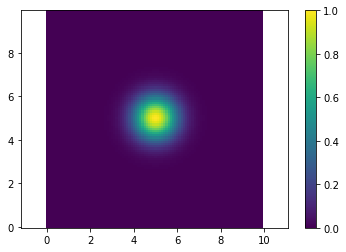

In [3]:
import matplotlib.pyplot as plt

u = np.zeros((nx, ny))
v = np.zeros((nx, ny))
eta = np.exp(-((c_grid.eta.x - 5) ** 2 + (c_grid.eta.y - 5) ** 2))

plt.pcolormesh(c_grid.eta.x, c_grid.eta.y, eta, shading='auto'); plt.axis('equal'); plt.colorbar();  # type: ignore


The numpy arrays needs to be turned into `Variable` objects which also know about the grid they are defined on. Finally the variables are joined into a state object which are used to express the current state or state changes of the system.

In [4]:
from multimodemodel import State, Variable

initial_state = State(
    u=Variable(u, c_grid.u),
    v=Variable(v, c_grid.v),
    eta=Variable(eta, c_grid.eta)
)

## Define the problem to solve

To solve the set of equations introduced initially, time stepping methods are applied. These methods need evaluations of all the right-hand sides of the governing equations. Hence, we define a function that is delivering exactly that. The function needs to take a `State` object as first argument and a parameter object (defining constants, etc.) as its second argument. More on the `Parameter` objects later.

In [5]:
from multimodemodel import (
    pressure_gradient_i,
    pressure_gradient_j,
    divergence_i,
    divergence_j,
)

def non_rotating_swe(state, params):
    rhs = (
        pressure_gradient_i(state, params)
        + pressure_gradient_j(state, params)
        + divergence_i(state, params)
        + divergence_j(state, params)
    )
    return rhs


Note that the different contributions, e.g. `pressure_gradient_i`, have the same signature as `non_rotating_swe` and return state increments.

Now we need to set some physical constants of the system, e.g. the depth of the fluid `H`, the integration bounds `t_0` and `t_end`, and the length of the time step `dt`. See the docstring of the `Parameter` class for more values to set, although not all are used in this example.

In [6]:
from multimodemodel import Parameters

params = Parameters(H=0.01, dt=.05, t_0=0., t_end=40.)

## Solve the problem

Now we have all necessary ingredients set up to solve the problem.
The only thing we need to do is to choose the time stepping scheme, the 3rd order Adams-Bashforth scheme here.
The final state of the problem is obtained by calling the `integrate` function with all the required arguments.

In [7]:
from multimodemodel import integrate, adams_bashforth3

for next_state in integrate(initial_state, params, RHS=non_rotating_swe, scheme=adams_bashforth3):
    pass

To visualize the output, we can use the handy `as_dataarray` property of the `Variable` class. It returns a copy of the data and grid information wrapped into a [`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html) which offers among many other things a very usefull and feature rich [plotting API](http://xarray.pydata.org/en/stable/user-guide/plotting.html).

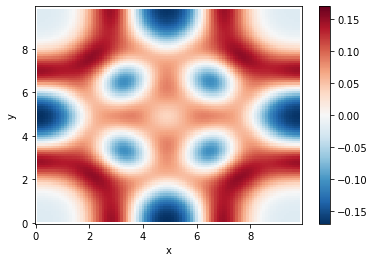

In [8]:
next_state.eta.as_dataarray.plot(x='x', y='y')